In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:
movies = pd.read_csv('data/movies_c.csv')
tags = pd.read_csv('data/tags_c.csv')
ratings = pd.read_csv('data/ratings_c.csv')


display(movies.head())
display(tags.head())
display(ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head()

/tmp/ipykernel_29508/3744492305.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Filter the movies df
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

### Feature Engineering


In [6]:
# Merge
merged = pd.merge(movies, tags, on='movieId', how='left')
# Drop useless columns.
merged.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


In [7]:
# Create a new DataFrame merged_df with a new metadata column from tags and genres.
merged.fillna("", inplace=True)
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
merged_df = pd.merge(movies, merged, on='movieId', how='left')
merged_df['metadata'] = merged_df[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

merged_df.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


### Create a content latent matrix from metadata


#### Count Vectorizer


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(merged_df['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=merged_df.index.tolist())
count_df.head()

/home/proctor/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
count_df.shape


(9724, 1675)

#### Dimensionality reduction


In [11]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=25)
latent_df = svd.fit_transform(count_df)

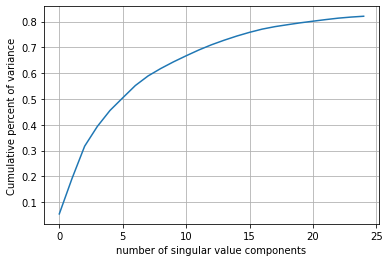

In [18]:
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [19]:
# keep the first 25 number of latent components.
n = 25 
latent_df = pd.DataFrame(latent_df[:,0:n], index=merged_df.title.tolist())
latent_df.shape

(9724, 25)

### Create a latent matrix from user ratings

In [20]:
# Merge
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
# Pivot
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

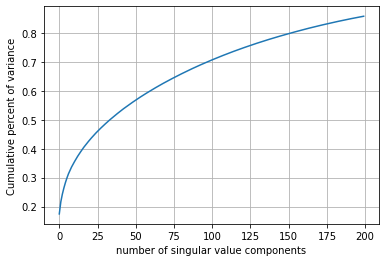

In [21]:
svd = TruncatedSVD(n_components=200)
latent_df_2 = svd.fit_transform(ratings2)
 
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [22]:
latent_df_2 = pd.DataFrame(latent_df_2, index=merged_df.title.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790050,8.807629,-2.198637,1.153306,1.387561,...,-0.139318,0.964066,1.029477,-1.489580,3.304461,-0.004028,-1.814816,-0.622651,1.172559,-3.231045
Jumanji (1995),20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359215,-3.821408,-3.394116,0.236474,...,0.856112,1.117316,0.256326,0.151034,-0.593528,1.185781,0.718953,-0.927685,2.461420,0.854055
Grumpier Old Men (1995),8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783433,-1.423027,-0.542292,3.270654,1.897236,...,1.036304,0.346357,-0.428738,-0.144177,-0.693559,-0.645704,-0.356591,1.108685,-0.938904,0.985971
Waiting to Exhale (1995),0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214720,-0.527368,0.079467,0.015616,...,0.045004,-0.112603,0.105713,-0.176579,0.100638,0.587000,0.141870,0.125111,0.204272,0.021007
Father of the Bride Part II (1995),6.071045,-2.673536,4.698195,-4.415807,-3.714221,-1.673627,1.297653,-1.308023,1.325734,1.229592,...,0.304929,0.171775,0.422238,-0.871493,-0.178282,0.319392,-1.166555,0.300516,0.315850,0.266886


In [23]:
latent_df_2.shape


(9724, 200)

### Search bar 

In [54]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [55]:
merged_df["clean_title"] = merged_df["title"].apply(clean_title)


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["title"])

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]
    
    return results

In [59]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

### Apply cosine similarity in content and colaborative matrices


In [36]:
merged_df.loc[merged_df['title'].str.contains("eat pray", case=False)] 

,movieId,title,genres,tag,metadata
7400,80551,Eat Pray Love (2010),Drama Romance,,Drama Romance


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df.loc['Interstellar (2014)']).reshape(1, -1)
v2 = np.array(latent_df_2.loc['Interstellar (2014)']).reshape(1, -1)

v3 = np.array(latent_df.loc['Eat Pray Love (2010)']).reshape(1, -1)
v4 = np.array(latent_df_2.loc['Eat Pray Love (2010)']).reshape(1, -1)

# Compute the cosine similartity of this movie with the others in the list
sim1 = cosine_similarity(latent_df, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

sim3 = cosine_similarity(latent_df, v3).reshape(-1)
sim4 = cosine_similarity(latent_df_2, v4).reshape(-1)


In [38]:
sim3

array([ 0.00028671,  0.00178208,  0.00032822, ..., -0.0023573 ,
       -0.00927358,  0.00433697])

In [48]:
hybrid_1 = ((sim1 + sim2)/2.0)
hybrid_2 = ((sim3 + sim4)/2.0)
hybrid_3 = ((hybrid_1 + hybrid_2)/2.0)

In [49]:

dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid_3} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index)

In [50]:
recommendation_df.sort_values('hybrid', ascending=False, inplace=True)
recommendation_df.head(10)

,content,collaborative,hybrid
Eat Pray Love (2010),-0.004405,0.000696,0.499073
Interstellar (2014),1.000000,1.000000,0.499073
Her (2013),0.614550,0.467834,0.474662
Lovers & Leavers (Kuutamolla) (2002),-0.004405,-0.006147,0.429606
"Time Traveler's Wife, The (2009)",0.614550,0.082838,0.429301
"Last Song, The (2010)",-0.004405,0.007585,0.421278
Letters to Juliet (2010),-0.004405,0.006415,0.420663
Solaris (2002),0.614550,0.134230,0.419682
Cloud Atlas (2012),0.738405,0.555927,0.412876
The Martian (2015),0.621344,0.654375,0.406548


In [2]:
# tags = pd.read_json('tags.json', lines=True)

# display(tags.head())


,tag,id
0,aardman,22
1,secret service,112
2,hillarious,167
3,christian,270
4,mummy,362


In [3]:
# tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1094 non-null   object
 1   id      1094 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.2+ KB


In [7]:
# metadata = pd.read_json('metadata_updated.json', lines=True)
# display(metadata.head())


,title,directedBy,starring,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",3.07620,113041,5


In [9]:
# metadata = metadata.rename(columns={'item_id': 'movieId'})

In [10]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   avgRating   84661 non-null  float64
 4   imdbId      84661 non-null  int64  
 5   movieId     84661 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ MB


In [11]:
# # Filter the movies df
# metadata = metadata[metadata.movieId.isin(ratings.movieId.unique().tolist())]
# metadata.shape

(59040, 6)

In [6]:
# ratings = pd.read_csv('ratings_25.csv')
# ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
# ratings = pd.read_json('ratings.json', lines=True)
# display(ratings.head())